# Train Interspeech

## Data

In [1]:
import pandas as pd

# Cargar el CSV para male
data = pd.read_csv('data/data_male.csv')
print(len(data))
# Eliminar filas con valores nulos solo en la columna 'text'
data = data.dropna(subset=['text'])
print(len(data))
data.head()

19842
19837


,FileName,text,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set,PodcastID,StratifyCol,NewPartition,PseudoEmo,InvEntropyNorm,PseudoEmoNum
0,MSP-PODCAST_0288_0019,"mr. [excess 00:01:24] also known as ike, bbc r...",H,5.333333,5.416667,4.750000,123,Male,Train,288,0288_123_H,Train,H,1.000000,1
1,MSP-PODCAST_3371_0004_0001,... i decided to take a trip to canada with my...,N,3.400000,4.800000,4.200000,1769,Male,Development,3371,3371_1769_N,Evaluation,N,1.000000,0
2,MSP-PODCAST_0153_0436,"just clowning in the studio, people.",H,5.777778,5.111111,5.444444,15,Male,Train,153,0153_15_H,Evaluation,H,1.000000,1
3,MSP-PODCAST_2979_0216,social distancing implies that we're being dis...,X,3.200000,4.000000,3.600000,1565,Male,Train,2979,2979_1565_X,Evaluation,N,0.246159,0
4,MSP-PODCAST_0917_0196,... in 2016. we won. okay. and our core messag...,N,4.800000,3.600000,4.800000,266,Male,Train,917,0917_266_N,Train,N,1.000000,0


In [2]:
# Filtrar los datos en tres conjuntos basados en la columna 'Split_Set'
train_df = data.loc[data['NewPartition'] == 'Train']
dev_df = data.loc[data['NewPartition'] == 'Evaluation']
test_df = data.loc[data['NewPartition'] == 'Test']

# Verifica las primeras filas de cada conjunto
print("Conjunto Train:")
print(train_df.head())

print("Conjunto Development:")
print(dev_df.head())

print("Conjunto Test:")
print(test_df.head())

Conjunto Train:
                FileName                                               text  \
0  MSP-PODCAST_0288_0019  mr. [excess 00:01:24] also known as ike, bbc r...   
4  MSP-PODCAST_0917_0196  ... in 2016. we won. okay. and our core messag...   
5  MSP-PODCAST_0040_0223   all those decent men and women around the wor...   
7  MSP-PODCAST_1702_0156  yeah. it's like they're in some sort of geomet...   
8  MSP-PODCAST_5495_0498  that's a very good point of view. i love that....   

  EmoClass    EmoAct    EmoVal    EmoDom  SpkrID Gender    Split_Set  \
0        H  5.333333  5.416667  4.750000     123   Male        Train   
4        N  4.800000  3.600000  4.800000     266   Male        Train   
5        N  2.750000  3.666667  3.666667     425   Male        Train   
7        N  5.000000  4.200000  5.600000     981   Male  Development   
8        H  4.800000  5.400000  4.800000    2865   Male        Train   

   PodcastID  StratifyCol NewPartition PseudoEmo  InvEntropyNorm  PseudoEmoN

In [3]:
# # Establecer la semilla para garantizar reproducibilidad
# seed = 42

# # Seleccionar aleatoriamente las primeras N filas del conjunto de entrenamiento
# train_df = train_df.sample(n=1000, random_state=seed)

# # Seleccionar aleatoriamente las primeras N filas del conjunto de desarrollo
# dev_df = dev_df.sample(n=250, random_state=seed)

In [16]:
num_labels = 8
id2label = dict(zip(train_df["PseudoEmoNum"], train_df["PseudoEmo"]))
label2id = dict(zip(train_df["PseudoEmo"], train_df["PseudoEmoNum"]))

In [5]:
# Convertir EmoClass a valores numéricos si es necesario
train_df['PseudoEmoNum'] = train_df['PseudoEmoNum'].astype(int)
dev_df['PseudoEmoNum'] = dev_df['PseudoEmoNum'].astype(int)

/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_58985/1053012838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['PseudoEmoNum'] = train_df['PseudoEmoNum'].astype(int)
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_58985/1053012838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['PseudoEmoNum'] = dev_df['PseudoEmoNum'].astype(int)


In [6]:
from datasets import Dataset
from transformers import AutoTokenizer

# Modelo
model_ckpt = "distilbert-base-uncased"

# Cargar el tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Función para tokenizar los datos
def tokenize_function(examples):
    # Verificar que estamos pasando una lista de textos
    texts = examples['text']
    return tokenizer(texts, padding="max_length", truncation=True)

# Asegurarse de que 'train_df' y 'dev_df' son objetos Dataset de Hugging Face
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)

# Tokenizamos ambos conjuntos de datos
train_dataset = train_dataset.map(tokenize_function, batched=True)
dev_dataset = dev_dataset.map(tokenize_function, batched=True)

# Renombrar columna de labels
train_dataset = train_dataset.rename_column("PseudoEmoNum", "labels")
dev_dataset = dev_dataset.rename_column("PseudoEmoNum", "labels")


/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 4430/4430 [00:00<00:00, 15095.86 examples/s]


## Code

In [7]:
from transformers import AutoTokenizer
import torch
print(torch.__version__)  # Esto debería mostrarte la versión de PyTorch instalada

2.5.1


In [8]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Obtener reporte completo
    report = classification_report(labels, predictions, output_dict=True)
    
    # Obtener la matriz de confusión
    conf_matrix = confusion_matrix(labels, predictions)
    
    # Extraer métricas para cada clase y globales
    metrics = {
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score'],
        # 'weighted_precision': report['weighted avg']['precision'],
        # 'weighted_recall': report['weighted avg']['recall'],
        'confusion_matrix': conf_matrix.tolist()  # Convertir a lista para asegurarse de que es serializable si es necesario
    }
    
    # # Añadir métricas específicas por clase si se requiere
    # for label, scores in report.items():
    #     if label not in ["accuracy", "macro avg", "weighted avg"]:
    #         metrics[f'{label}_precision'] = scores['precision']
    #         metrics[f'{label}_recall'] = scores['recall']
    #         metrics[f'{label}_f1'] = scores['f1-score']
    #         metrics[f'{label}_support'] = scores['support']
    
    return metrics

In [10]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    #push_to_hub=True,
    log_level="error"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer
)

/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_58985/2523129008.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Confusion Matrix
1,0.371400,0.355018,0.451919,0.129817,0.342668,"[[1549, 265, 0, 0, 0, 0, 0, 0], [521, 453, 0, 0, 0, 0, 0, 0], [417, 183, 0, 0, 0, 0, 0, 0], [314, 37, 0, 0, 0, 0, 0, 0], [121, 33, 0, 0, 0, 0, 0, 0], [216, 71, 0, 0, 0, 0, 0, 0], [80, 37, 0, 0, 0, 0, 0, 0], [106, 27, 0, 0, 0, 0, 0, 0]]"
2,0.320400,0.392355,0.454176,0.129276,0.342129,"[[1593, 221, 0, 0, 0, 0, 0, 0], [555, 419, 0, 0, 0, 0, 0, 0], [426, 174, 0, 0, 0, 0, 0, 0], [329, 22, 0, 0, 0, 0, 0, 0], [125, 29, 0, 0, 0, 0, 0, 0], [222, 65, 0, 0, 0, 0, 0, 0], [91, 26, 0, 0, 0, 0, 0, 0], [110, 23, 0, 0, 0, 0, 0, 0]]"
3,0.228100,0.651491,0.443792,0.127281,0.335728,"[[1534, 280, 0, 0, 0, 0, 0, 0], [542, 432, 0, 0, 0, 0, 0, 0], [455, 145, 0, 0, 0, 0, 0, 0], [321, 30, 0, 0, 0, 0, 0, 0], [124, 30, 0, 0, 0, 0, 0, 0], [211, 76, 0, 0, 0, 0, 0, 0], [91, 26, 0, 0, 0, 0, 0, 0], [109, 24, 0, 0, 0, 0, 0, 0]]"
4,0.138500,0.976250,0.430248,0.126001,0.331397,"[[1381, 433, 0, 0, 0, 0, 0, 0], [449, 525, 0, 0, 0, 0, 0, 0], [368, 232, 0, 0, 0, 0, 0, 0], [295, 56, 0, 0, 0, 0, 0, 0], [112, 42, 0, 0, 0, 0, 0, 0], [184, 103, 0, 0, 0, 0, 0, 0], [71, 46, 0, 0, 0, 0, 0, 0], [97, 36, 0, 0, 0, 0, 0, 0]]"
5,0.062500,1.227323,0.435440,0.122193,0.326099,"[[1554, 260, 0, 0, 0, 0, 0, 0], [599, 375, 0, 0, 0, 0, 0, 0], [456, 144, 0, 0, 0, 0, 0, 0], [321, 30, 0, 0, 0, 0, 0, 0], [134, 20, 0, 0, 0, 0, 0, 0], [220, 67, 0, 0, 0, 0, 0, 0], [94, 23, 0, 0, 0, 0, 0, 0], [109, 24, 0, 0, 0, 0, 0, 0]]"
6,0.031900,1.476157,0.430474,0.124144,0.328085,"[[1449, 365, 0, 0, 0, 0, 0, 0], [516, 458, 0, 0, 0, 0, 0, 0], [406, 194, 0, 0, 0, 0, 0, 0], [309, 42, 0, 0, 0, 0, 0, 0], [121, 33, 0, 0, 0, 0, 0, 0], [205, 82, 0, 0, 0, 0, 0, 0], [84, 33, 0, 0, 0, 0, 0, 0], [104, 29, 0, 0, 0, 0, 0, 0]]"
7,0.016900,1.582799,0.434989,0.124145,0.329188,"[[1503, 311, 0, 0, 0, 0, 0, 0], [550, 424, 0, 0, 0, 0, 0, 0], [432, 168, 0, 0, 0, 0, 0, 0], [312, 39, 0, 0, 0, 0, 0, 0], [130, 24, 0, 0, 0, 0, 0, 0], [210, 77, 0, 0, 0, 0, 0, 0], [86, 31, 0, 0, 0, 0, 0, 0], [106, 27, 0, 0, 0, 0, 0, 0]]"
8,0.010500,1.692365,0.432957,0.125140,0.330432,"[[1449, 365, 0, 0, 0, 0, 0, 0], [505, 469, 0, 0, 0, 0, 0, 0], [395, 205, 0, 0, 0, 0, 0, 0], [306, 45, 0, 0, 0, 0, 0, 0], [120, 34, 0, 0, 0, 0, 0, 0], [203, 84, 0, 0, 0, 0, 0, 0], [84, 33, 0, 0, 0, 0, 0, 0], [105, 28, 0, 0, 0, 0, 0, 0]]"
9,0.003400,1.777512,0.436343,0.124420,0.330550,"[[1504, 310, 0, 0, 0, 0, 0, 0], [545, 429, 0, 0, 0, 0, 0, 0], [411, 189, 0, 0, 0, 0, 0, 0], [313, 38, 0, 0, 0, 0, 0, 0], [120, 34, 0, 0, 0, 0, 0, 0], [207, 80, 0, 0, 0, 0, 0, 0], [85, 32, 0, 0, 0, 0, 0, 0], [107, 26, 0, 0, 0, 0, 0, 0]]"
10,0.004300,1.808299,0.437020,0.126666,0.334243,"[[1450, 364, 0, 0, 0, 0, 0, 0], [488, 486, 0, 0, 0, 0, 0, 0], [386, 214, 0, 0, 0, 0, 0, 0], [300, 51, 0, 0, 0, 0, 0, 0], [115, 39, 0, 0, 0, 0, 0, 0], [195, 92, 0, 0, 0, 0, 0, 0], [82, 35, 0, 0, 0, 0, 0, 0], [104, 29, 0, 0, 0, 0, 0, 0]]"


/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

TrainOutput(global_step=12500, training_loss=0.11869535918651149, metrics={'train_runtime': 10489.7489, 'train_samples_per_second': 9.532, 'train_steps_per_second': 1.192, 'total_flos': 1.324541519161344e+16, 'train_loss': 0.11869535918651149, 'epoch': 10.0})

In [14]:
preds_output = trainer.predict(dev_dataset)
preds_metrics = preds_output.metrics
preds_metrics

/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

{'test_loss': 1.80829918384552,
 'test_accuracy': 0.437020316027088,
 'test_macro_f1': 0.1266659484885249,
 'test_weighted_f1': 0.33424337153138534,
 'test_confusion_matrix': [[1450, 364, 0, 0, 0, 0, 0, 0],
  [488, 486, 0, 0, 0, 0, 0, 0],
  [386, 214, 0, 0, 0, 0, 0, 0],
  [300, 51, 0, 0, 0, 0, 0, 0],
  [115, 39, 0, 0, 0, 0, 0, 0],
  [195, 92, 0, 0, 0, 0, 0, 0],
  [82, 35, 0, 0, 0, 0, 0, 0],
  [104, 29, 0, 0, 0, 0, 0, 0]],
 'test_runtime': 135.57,
 'test_samples_per_second': 32.677,
 'test_steps_per_second': 4.086}

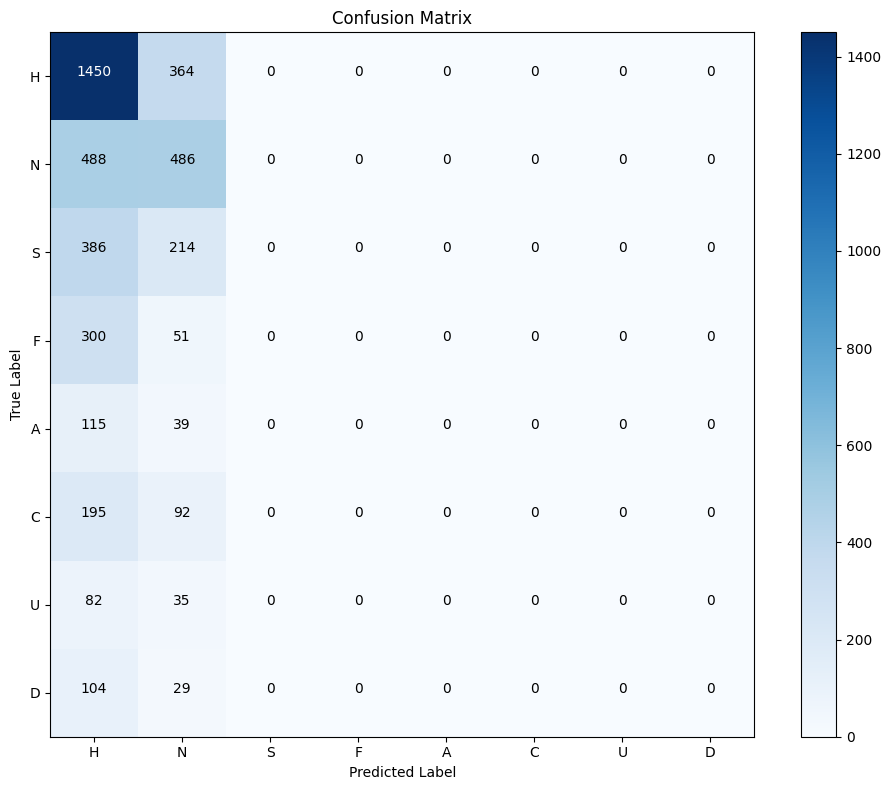

In [17]:
import matplotlib.pyplot as plt
import numpy as np

labels = label2id.keys()
conf_matrix = preds_metrics['test_confusion_matrix']

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Agregar etiquetas
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Rótulos de valores dentro de cada celda
conf_matrix = np.array(conf_matrix)

# Calcular el umbral
thresh = conf_matrix.max() / 2
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(
        j, i, format(conf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black"
    )

# Etiquetas de los ejes
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()